In [9]:
import os
import torch
import torchvision.transforms as T
import torch.nn as nn
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import numpy as np
from tqdm import tqdm
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader

In [10]:
architecture = "UNET"
encoder = "resnet34"
preprocessing = smp.encoders.get_preprocessing_fn(encoder)
print(preprocessing)

functools.partial(<function preprocess_input at 0x7fcca3a36320>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [11]:
class PILToTensor_for_targets:

    def __call__(self,  target):
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        # to make a binary mask, set gray(2) to 0 and black and white pet to 1
        target[(target == 1) | (target == 3)] = 1
        target[target == 2] = 0
        #target = scipy.ndimage.median_filter(target, size=(3,3))
        target = target[None, :, :]
        return target



In [12]:
# transform like preprocess required by the network
tf_rgb = T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.CenterCrop(256),
    #T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

tf_gray = T.Compose([
    T.Resize(256),
    T.CenterCrop(256),
    PILToTensor_for_targets(),
])


In [13]:
train_dataset = OxfordIIITPet(root = "dataset", split="trainval", target_types="segmentation", 
                               transform=tf_rgb, target_transform=tf_gray, download=True)

test_dataset = OxfordIIITPet(root = "dataset", split="test", target_types="segmentation",
                                transform=tf_rgb, target_transform=tf_gray, download=True)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [3380, 300])

print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))

3380
3669
300


In [14]:
# Hyperparameters:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 8
LOAD_MODEL = False
NUM_WORKERS = os.cpu_count()


In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

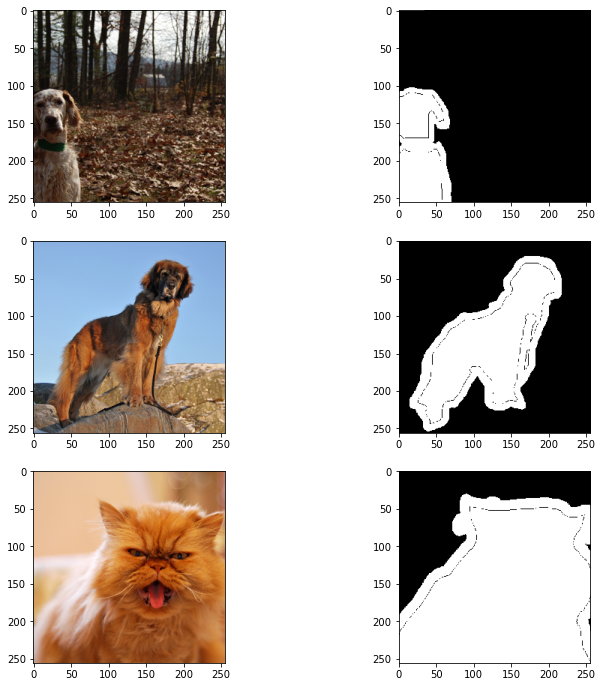

In [16]:
_, axx = plt.subplots(3,2, figsize=(12,12))
for i, ((data, target), axis) in enumerate(zip(train_dataloader,axx)):
    data =  torch.permute(data[i], (1, 2, 0))
    axis[0].imshow(data)
    axis[1].imshow(target[i].squeeze(0), cmap="gray")

In [17]:
class SegmentationBackbone(nn.Module):

    def __init__(self, architecture, encoder, encoder_weights, in_channels, out_channels, **kwargs):
        super().__init__()
        self.model = smp.create_model(architecture, encoder_name=encoder, encoder_weights=encoder_weights,
            in_channels=in_channels, classes=out_channels, **kwargs)


    def forward(self, image):
        mask = self.model(image)
        return mask


In [18]:
def train(loader, model, optimizer, loss_fn, scaler):
    model = model.to(device=DEVICE)


    for data, targets in (pbar := tqdm(loader)):
        data = data.to(device=DEVICE)
        targets = targets.float().to(device=DEVICE)


        # forward pass
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        pbar.set_postfix(loss=loss.item())

In [19]:
model = SegmentationBackbone(architecture="UNET", encoder="resnet34", encoder_weights="imagenet", 
    decoder_channels=[16,32,64,128,256], in_channels=3, out_channels=1, activation="identity")
loss_fn = nn.BCEWithLogitsLoss()
#loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=False)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train(train_dataloader, model, optimizer, loss_fn, scaler)

    # save the model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    #utils.save_checkpoint(checkpoint)

    # print accuracy
    #utils.check_accuracy(valid_dataloader, model, device=DEVICE)

model.to(device="cpu")
torch.cuda.empty_cache()

100%|██████████| 212/212 [00:53<00:00,  3.97it/s, loss=0.0895]


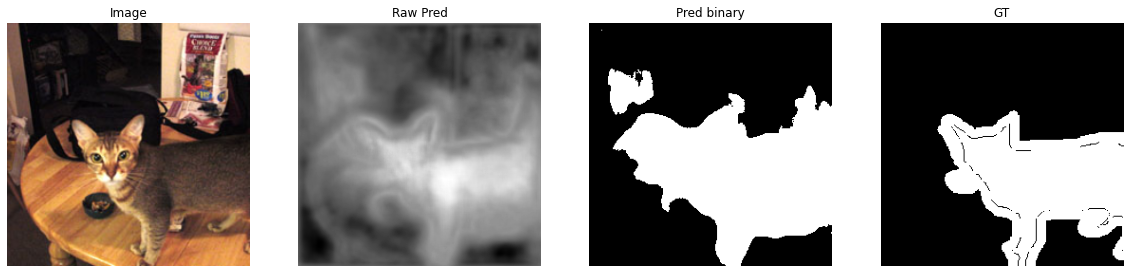

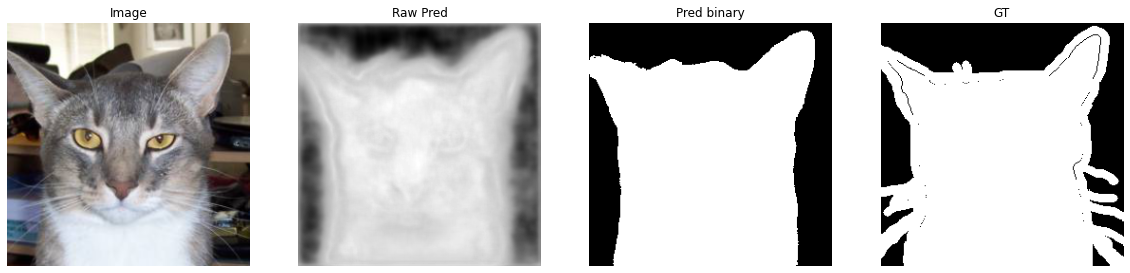

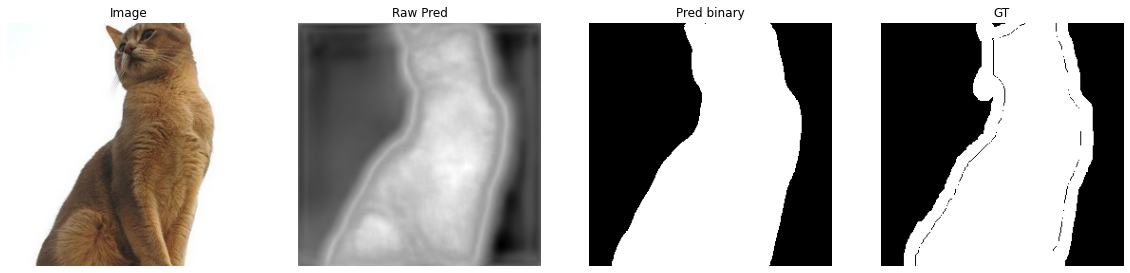

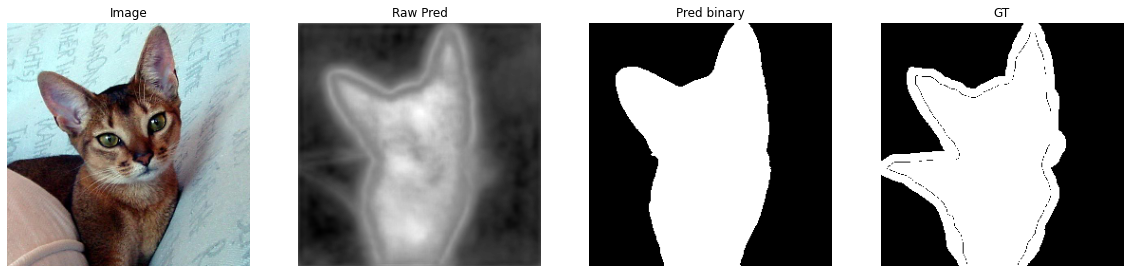

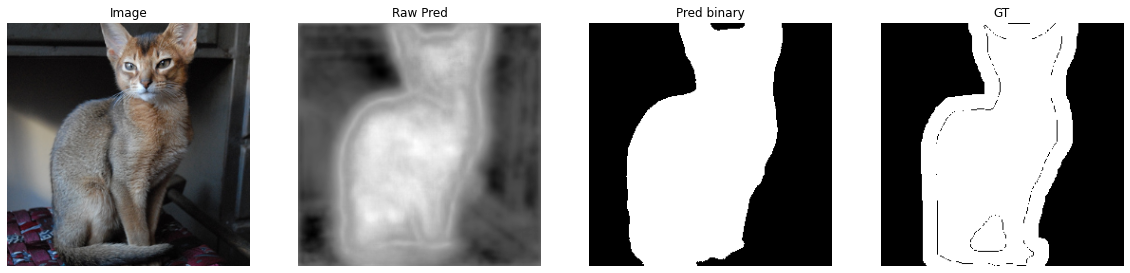

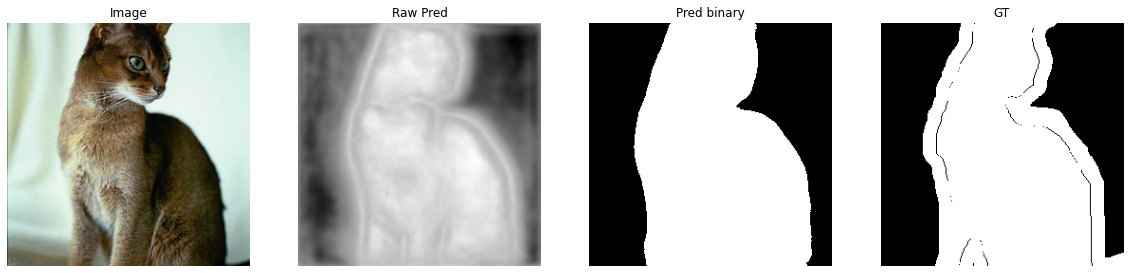

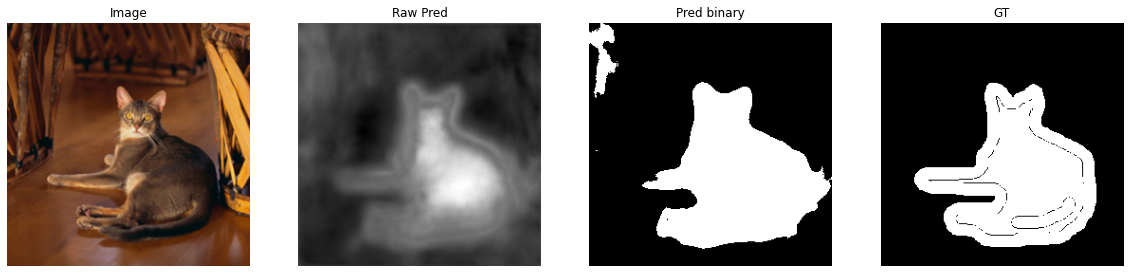

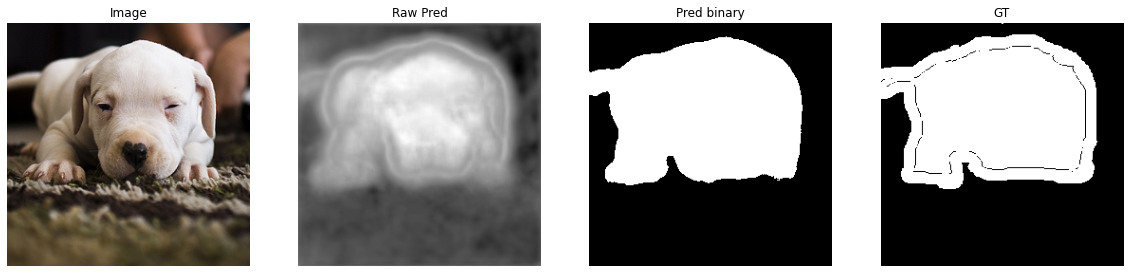

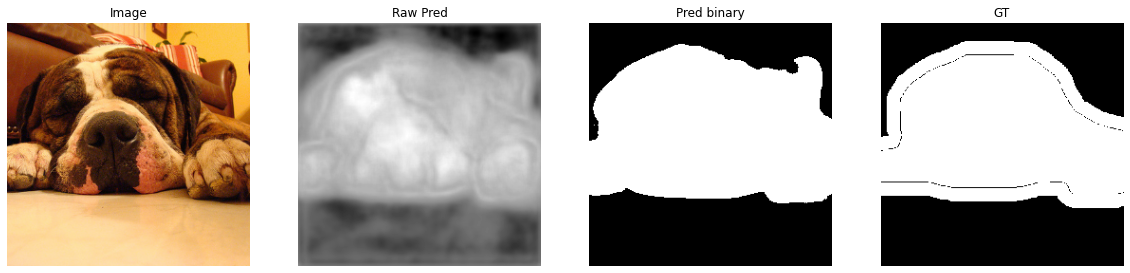

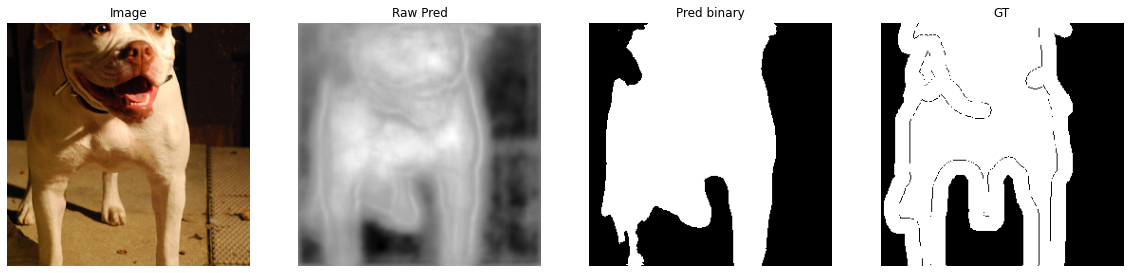

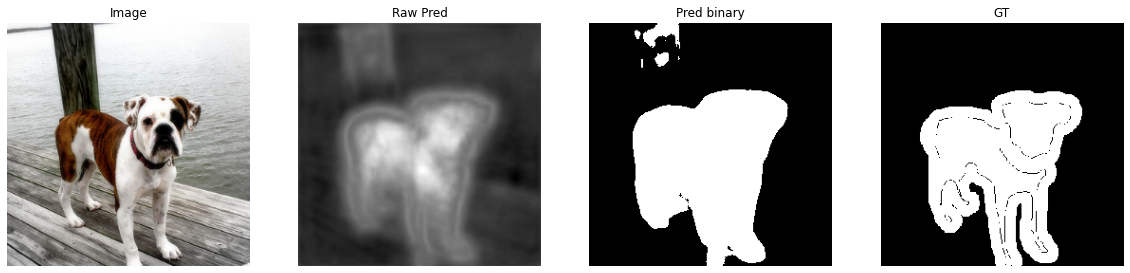

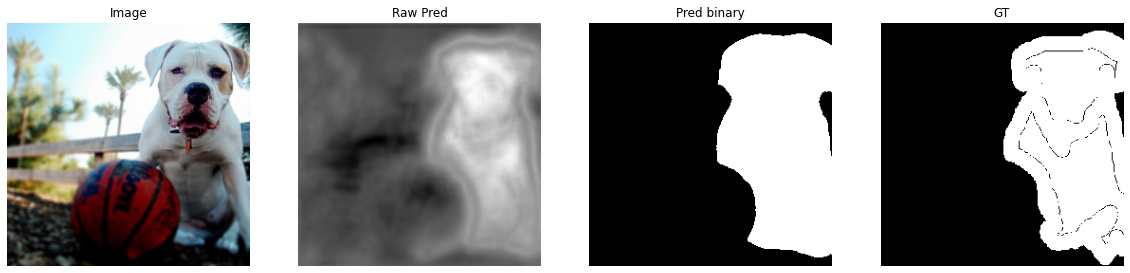

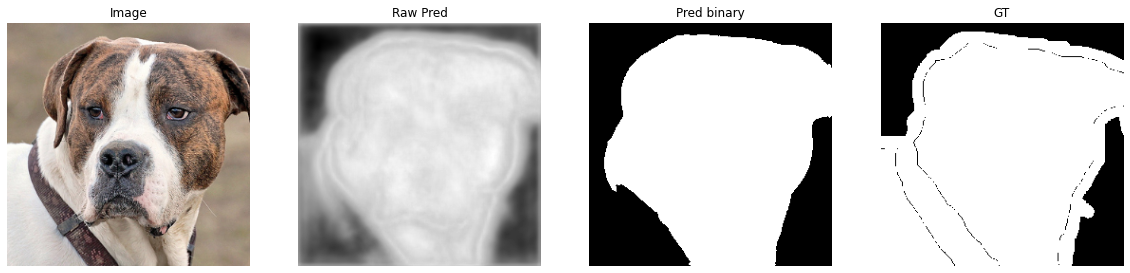

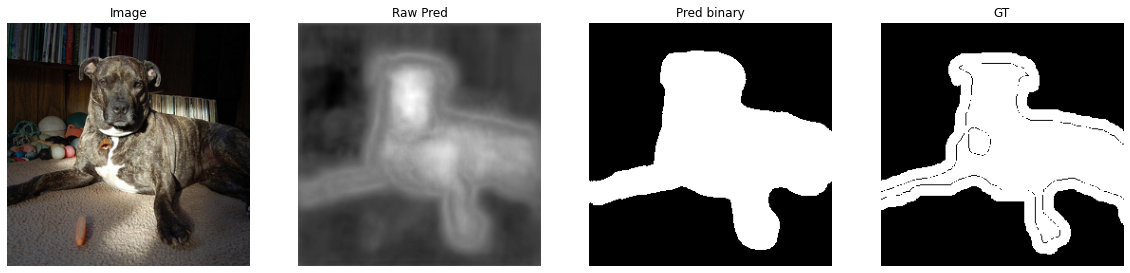

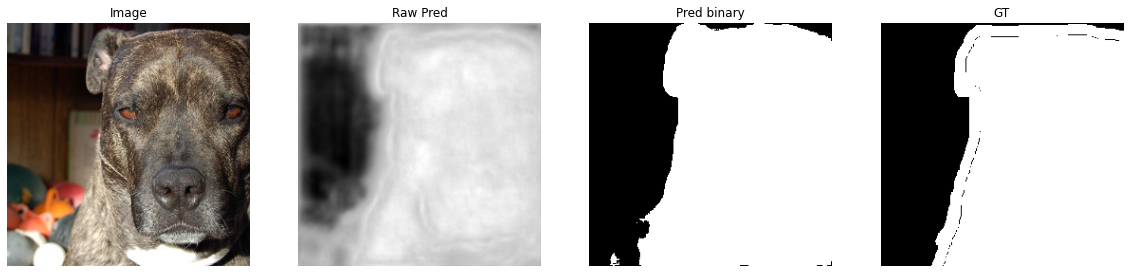

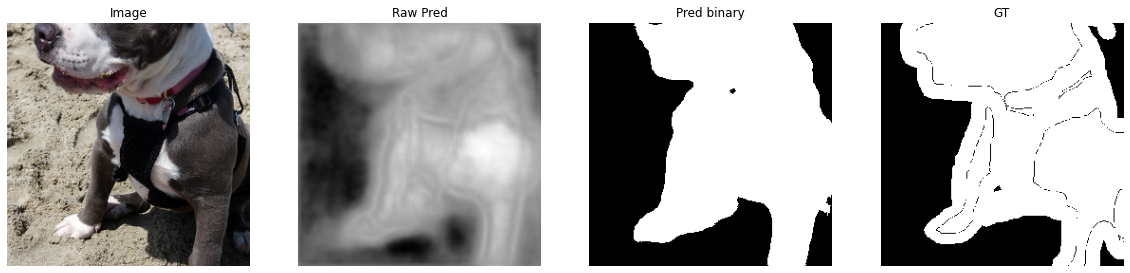

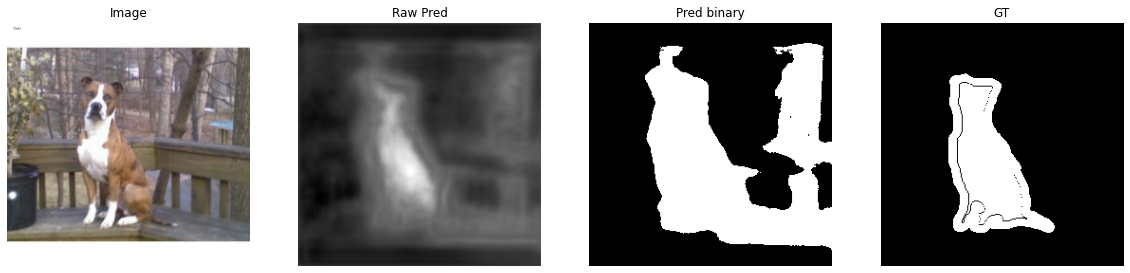

In [20]:
with torch.no_grad():
    i = 0
    for img, target in  test_dataloader:
        
        _, ax = plt.subplots(1, 4, figsize=(20,10))
        image = img[0]
        pred = model(image.unsqueeze(0))
        target = target[0]


        image = torch.permute(image, (1, 2, 0))
        pred = pred.squeeze()
        target = torch.permute(target, (1, 2, 0))
        # apply probabilities
        pred_raw = pred.clone().detach()
        pred[pred > 0.5] = 1
        pred[pred < 0.5] = 0

        ax[0].set_title("Image")
        ax[0].imshow(image)
        ax[1].set_title("Raw Pred")
        ax[1].imshow(pred_raw, cmap="gray")
        ax[2].set_title("Pred binary")
        ax[2].imshow(pred, cmap="gray")
        ax[3].set_title("GT")
        ax[3].imshow(target, cmap="gray")
        ax[0].axis("off")
        ax[1].axis("off")
        ax[2].axis("off")
        ax[3].axis("off")
        if i != 16:
            i +=1
        else:
            break

